In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

This is how I convert DICOM to NIFTI:

In [2]:
import dicom2nifti

dicom2nifti.dicom_series_to_nifti(original_dicom_directory='8', output_file='/Users/polzovatel/Desktop/B-brain/357/norm.nii', reorient_nifti=True)

{'NII_FILE': '/Users/polzovatel/Desktop/B-brain/357/norm.nii',
 'BVAL_FILE': '/Users/polzovatel/Desktop/B-brain/357/norm.bval',
 'BVEC_FILE': '/Users/polzovatel/Desktop/B-brain/357/norm.bvec',
 'NII': <nibabel.nifti1.Nifti1Image at 0x19a5a2050>,
 'BVAL': array([   0,    0,    0,    0, 1500, 1500, 1499, 1499, 1499, 1500, 1499,
        1500, 1501, 1501, 1498, 1500, 1500, 1501, 1500, 1501, 1501, 1499,
        1501, 1499, 1500, 1502, 1499, 1500, 1500, 1501, 1500, 1501, 1499,
        1500, 1500, 1502, 1500, 1499, 1499, 1498, 1500, 1499, 1500, 1501,
        1502, 1500, 1499, 1500, 1500, 1500, 1499, 1499, 1500, 1499, 1500,
        1499, 1499, 1501, 1500, 1500, 1500, 1501, 1500, 1500, 1498, 1499,
        1500, 1500], dtype=int32),
 'BVEC': array([[-0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        ],
        [-1.        ,  0.        ,  0.        ],
        [-0.00

In [3]:
import nibabel as nib
img = nib.load('norm.nii')
data = img.get_fdata()

In [45]:
t1 = nib.load('t1.nii')

In [4]:
print(data.shape)

(256, 256, 64, 68)


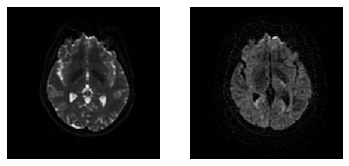

In [5]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

In [6]:
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

bvals, bvecs = read_bvals_bvecs('norm.bval', 'norm.bvec')
gtab = gradient_table(bvals, bvecs)

In [7]:
from dipy.segment.mask import median_otsu
#Not sure if it's helpful, but I have some misterious faith that some averaging could improve segmentation. 
b0_mask, mask = median_otsu(((data[:,:,:,0]+data[:,:,:,1]+data[:,:,:,3])/3), median_radius=2,
                            numpass=1)

In [8]:
from dipy.io.image import save_nifti
b0_array = data[:,:,:,0]
b0_save_path = 'norm_b0.nii'
save_nifti(b0_save_path, b0_array, img.affine)

In [9]:
save_nifti('mask.nii', mask*1, img.affine)

In [10]:
import nilearn.plotting as nip

/Users/polzovatel/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


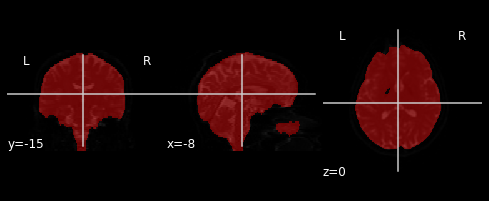

In [11]:
nip.plot_roi('mask.nii', bg_img='norm_b0.nii', 
             cmap=nip.cm.bwr_r, alpha=0.4)

In [12]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.csdeconv import auto_response

In [13]:
response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [14]:
from dipy.reconst.dti import TensorModel

tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(data, mask)

In [48]:
fa = tensor_fit.fa
fa = np.clip(fa, 0, 1)
save_nifti('ohbm_dipy_fa.nii.gz', fa, img.affine)

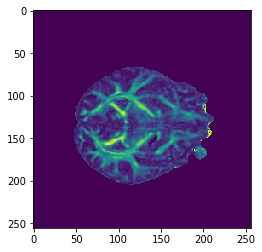

In [47]:
plt.imshow(fa[:,:,32])

In [17]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.csdeconv import auto_response

response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [18]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric362')

In [19]:
from dipy.direction import peaks_from_model

csd_peaks = peaks_from_model(model=csd_model,
                             data=data,
                             sphere=sphere,
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

In [20]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csd_peaks.gfa, .25)

In [21]:
from dipy.tracking.utils import random_seeds_from_mask

In [22]:
img.affine

array([[  -0.97659999,   -0.        ,    0.        ,  122.7539978 ],
       [   0.        ,    0.97659999,    0.        , -135.58000183],
       [   0.        ,   -0.        ,    2.5       ,  -87.54250336],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [23]:
seeds = random_seeds_from_mask(fa > 0.3, seeds_count=1, affine=img.affine)

In [24]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

streamlines_generator = LocalTracking(csd_peaks, stopping_criterion, seeds,
                                      affine=img.affine, step_size=.5)
streamlines = Streamlines(streamlines_generator)
print(len(streamlines))

227135


In [25]:
from dipy.tracking.utils import length
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram

In [26]:
lengths = list(length(streamlines))

length_threshold = 180
long_streamlines = [] 
for i,sl in enumerate(streamlines):
    if lengths[i] > length_threshold:
        long_streamlines.append(sl)

In [27]:
save_trk(Tractogram(long_streamlines, affine_to_rasmm=img.affine),
         'det_streamlines_long.trk')

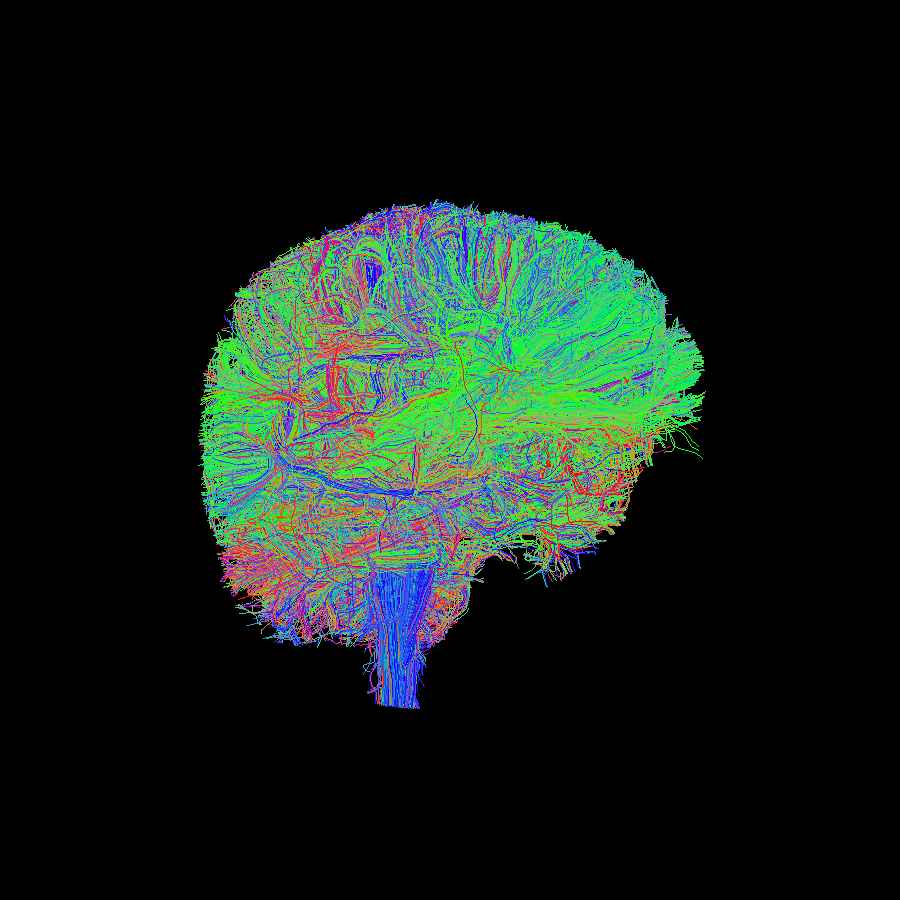

In [28]:
from dipy.viz import actor, window
from IPython.display import Image

ren = window.Renderer()
ren.add(actor.line(long_streamlines))

window.show(ren, size=(900, 900))
window.record(ren, out_path='det_streamlines_long.png', size=(900, 900))
    
Image('det_streamlines_long.png')

## So, 

First, I use the Tractogram function. 

In [29]:
save_trk(Tractogram(long_streamlines, affine_to_rasmm=img.affine),
         'first.trk')

I'm gonne compare the result with the output of the StatefulTractogram function. 

In [30]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

sft = StatefulTractogram(long_streamlines, img, Space.RASMM)
save_trk(sft, "second.trk")

Somehow the difference is quite outstanding:

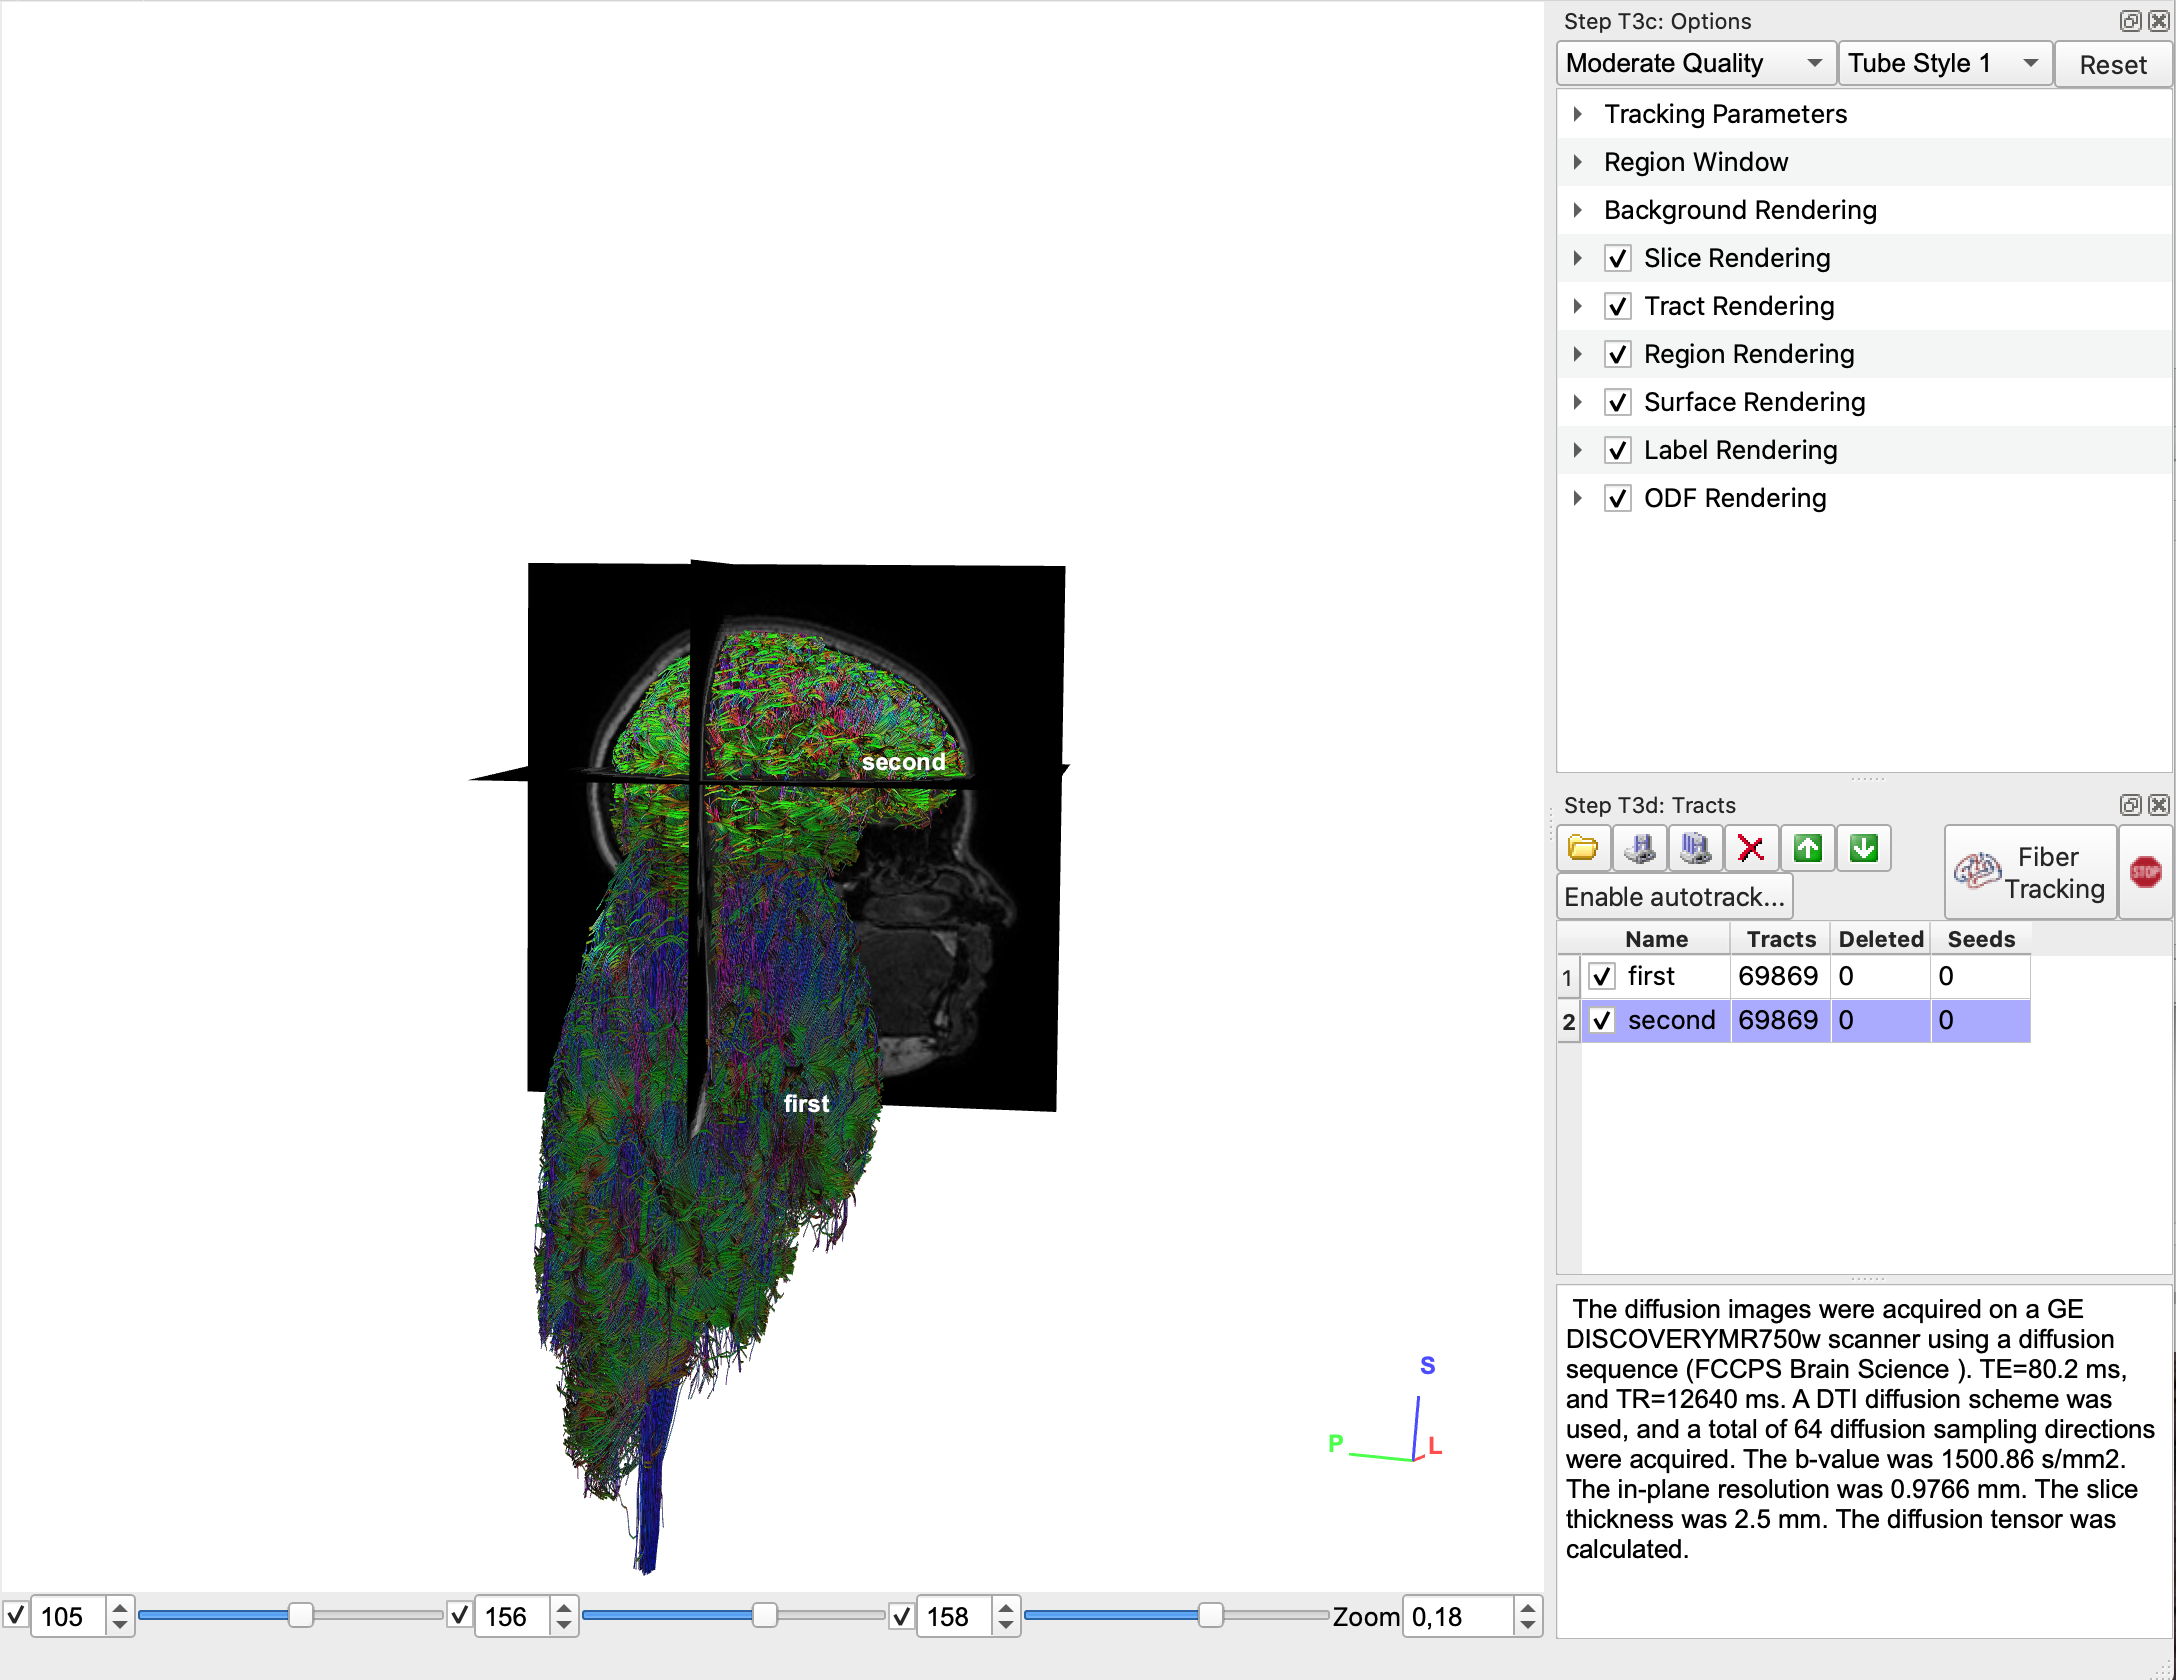

In [31]:
Image('screenshot.png')

But what I really can't handle is this. 

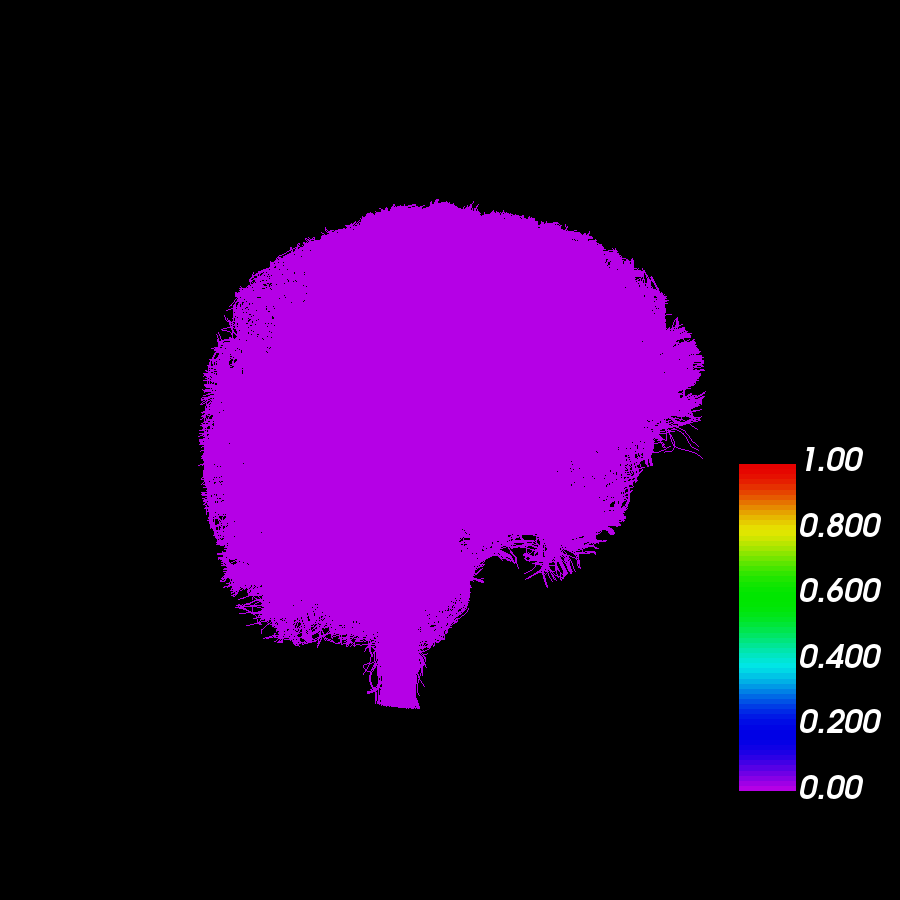

In [32]:
stream_actor = actor.line(long_streamlines, fa, linewidth=0.1)
bar = actor.scalar_bar()

ren.clear()
ren.add(stream_actor)
ren.add(bar)

window.show(ren, size=(600, 600), reset_camera=False)
window.record(ren, out_path='out.png', size=(900, 900))
    
Image('out.png')

In [33]:
from dipy.tracking.streamline import transform_streamlines
bundle_native = transform_streamlines(long_streamlines, np.linalg.inv(img.affine))

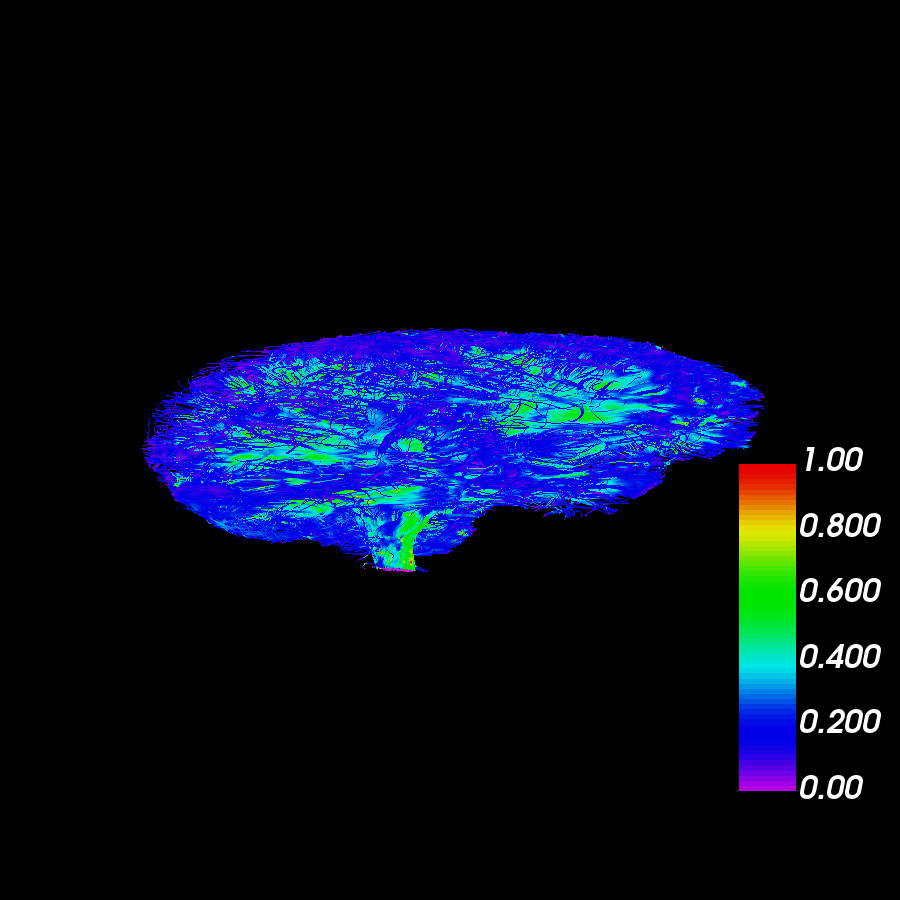

In [34]:
stream_actor = actor.line(bundle_native, fa, linewidth=0.1)
bar = actor.scalar_bar()

ren.clear()
ren.add(stream_actor)
ren.add(bar)

window.show(ren, size=(600, 600), reset_camera=False)
window.record(ren, out_path='flathead.png', size=(900, 900))
    
Image('flathead.png')

In [36]:
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram

save_trk(Tractogram(bundle_native, affine_to_rasmm=img.affine),
         'wh.trk')

In [42]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

sft = StatefulTractogram(bundle_native, img, Space.RASMM)
save_trk(sft, "whaaa.trk", bbox_valid_check=False)

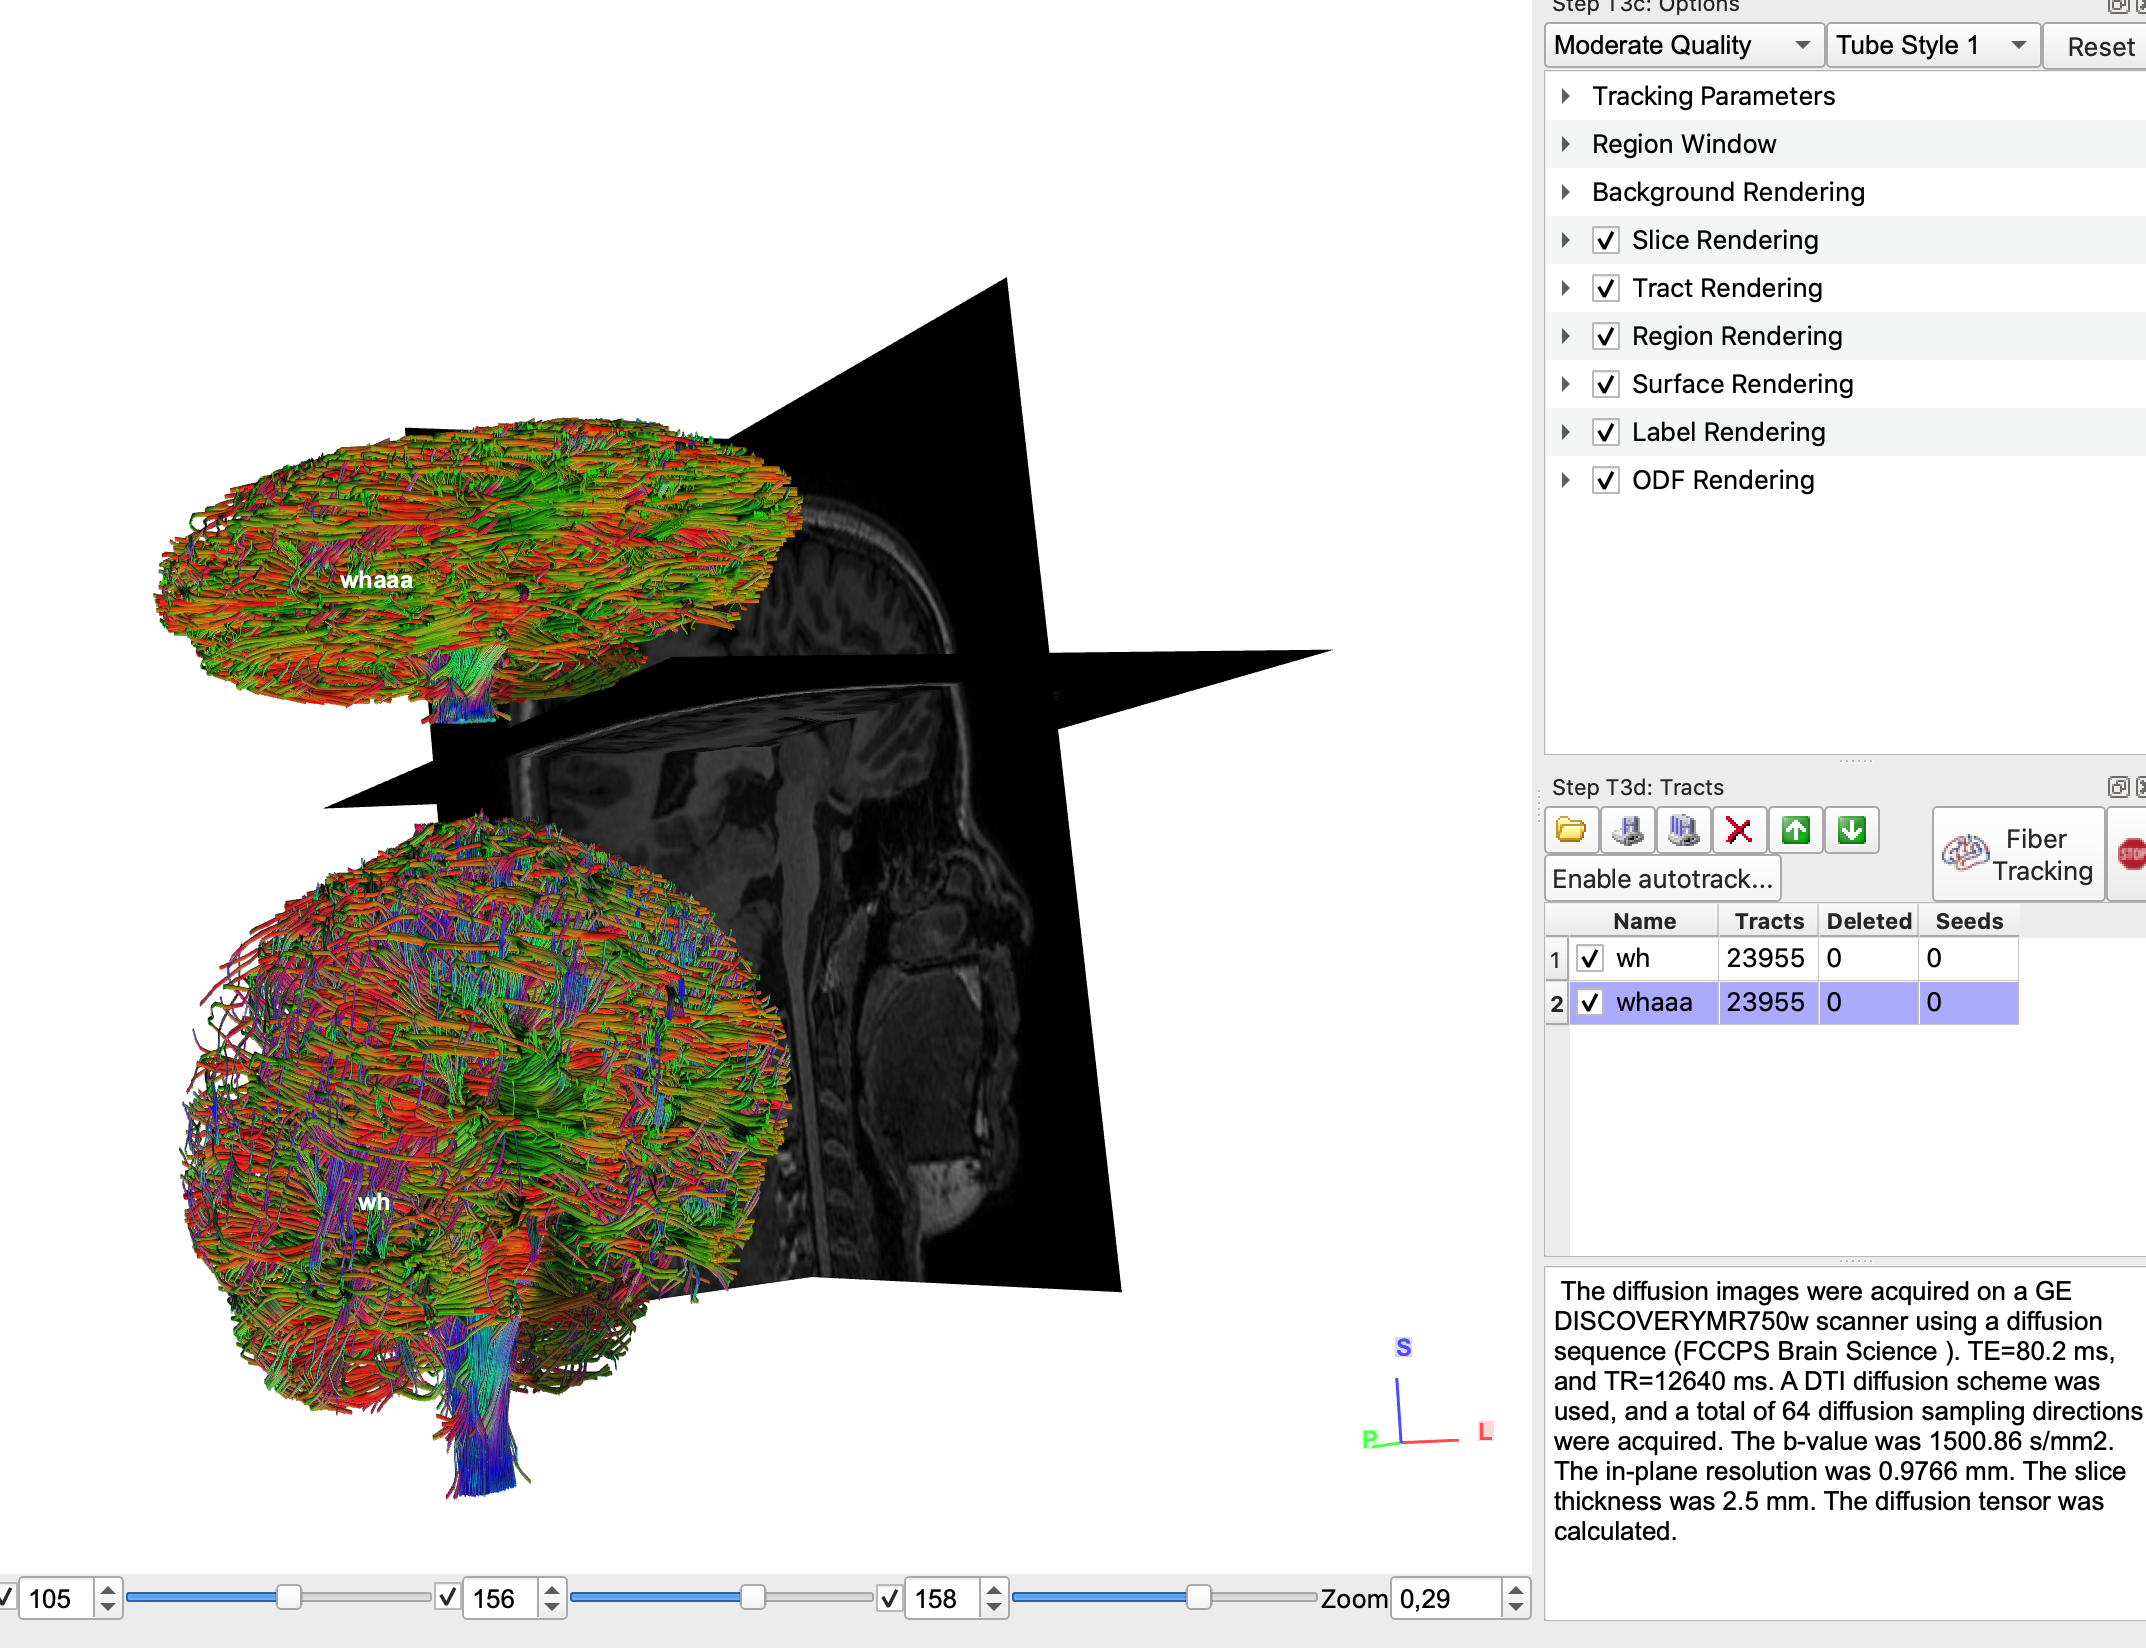

In [44]:
Image('t.png')